# Sydney Toll Roads - Fun for the whole family
All the toll data in sydney is availble for free download! How nice of them. Let's explore the data and find out some interesting insights. Firstly download the data.... This can probably be done in Python - but I find it super easy in BASH. Or you can manually download it too, but that is no fun.

In [1]:
#Import the modules we will need
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

In [2]:
#Or load in more data, like all the CCT data
all_files = glob.glob("data/CCT*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,parse_dates=[['Date', 'IntervalStart']])
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
print("Done")

Done


In [3]:
#What does it look like?
df.head()

,Date_IntervalStart,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
0,2008-11-26,CCT,200902,00:14,1,Car,East,E,Mainline Eastbound,-33.8,151.2,Mainline Gantry,26
1,2008-11-26,CCT,200902,00:14,1,Truck,East,E,Mainline Eastbound,-33.8,151.2,Mainline Gantry,0
2,2008-11-26,CCT,200902,00:14,1,Car,SJY,N,Sir John Young,-33.8,151.2,Ramp Gantry,8
3,2008-11-26,CCT,200902,00:14,1,Truck,SJY,N,Sir John Young,-33.8,151.2,Ramp Gantry,0
4,2008-11-26,CCT,200902,00:14,1,Car,West,W,Mainline Westbound,-33.8,151.2,Mainline Gantry,16


In [4]:
df.describe()

,FinancialQtrID,Version,GantryGPSLatitude,GantryGPSLongitude,TotalVolume
count,2.334528e+06,2.334528e+06,2.334528e+06,2.334528e+06,2.334528e+06
mean,2.014480e+05,1.045398e+00,-3.380000e+01,1.512000e+02,6.422005e+01
std,3.226971e+02,2.978858e-01,7.105429e-15,2.842172e-13,9.515174e+01
min,2.009020e+05,1.000000e+00,-3.380000e+01,1.512000e+02,0.000000e+00
25%,2.012010e+05,1.000000e+00,-3.380000e+01,1.512000e+02,1.000000e+00
50%,2.014040e+05,1.000000e+00,-3.380000e+01,1.512000e+02,7.000000e+00
75%,2.017030e+05,1.000000e+00,-3.380000e+01,1.512000e+02,1.120000e+02
max,2.020020e+05,3.000000e+00,-3.380000e+01,1.512000e+02,8.330000e+02


/home/nbutter/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([733042., 733773., 734503., 735234., 735964., 736695., 737425.]),
 <a list of 7 Text xticklabel objects>)

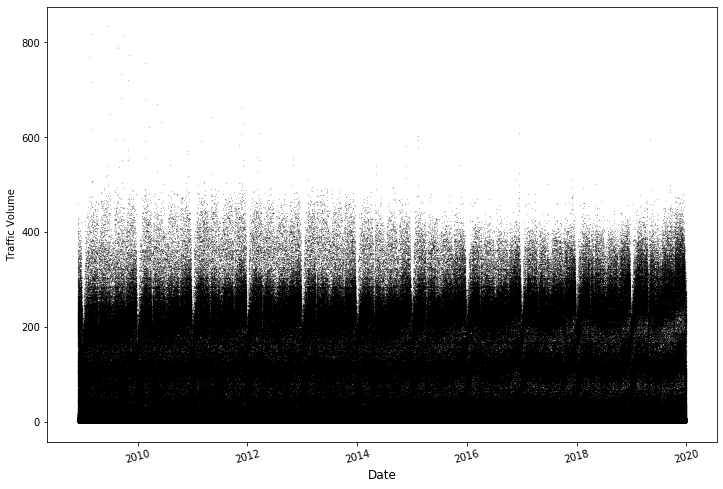

In [5]:
#Plot all the data, just time vs volume
plt.figure(figsize=(12,8)) 
plt.plot(df["Date_IntervalStart"],df["TotalVolume"].values,
         color='black', marker='.',markersize=0.2,linewidth=0.0)

plt.xlabel('Date',fontsize=12)
plt.ylabel('Traffic Volume')
plt.xticks(rotation=15)

In [6]:
"{:,} Total Trips".format(df["TotalVolume"].sum())

'149,923,514 Total Trips'

In [7]:
print("By my count that is about ", df["TotalVolume"].sum()/10/365/24/60, " per minute")
print("At $5 a trip, that is a good income - just for the Cross City Tunnel.")

By my count that is about  28.524260654490107  per minute
At $5 a trip, that is a good income - just for the Cross City Tunnel.


We can continue exploring this data in several different ways. We are dealing with a hefty dataset, so keep that in mind.

In [8]:
#So let's load in a single month of data
filename='data/CCT_trips_2017-11.csv'
dfmonth=pd.read_csv(filename,header = 0,parse_dates=[['Date', 'IntervalStart']])

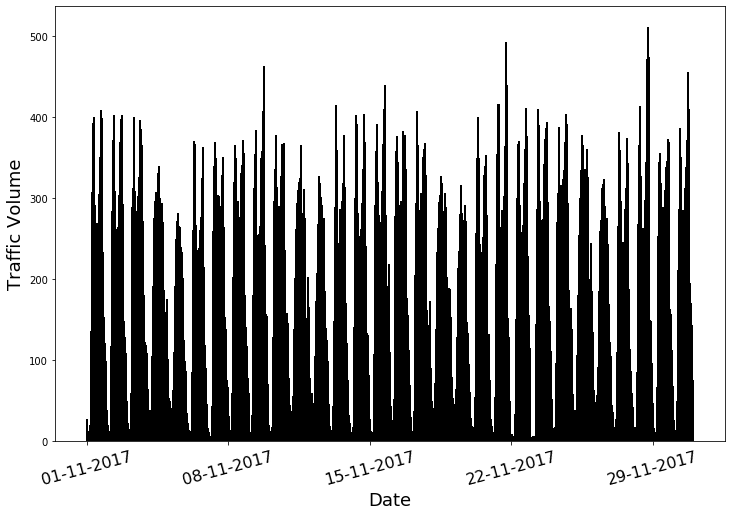

In [9]:
#Plot just the month of data
plt.figure(figsize=(12,8)) 
plt.bar(dfmonth.Date_IntervalStart.values,dfmonth["TotalVolume"].values,color='black',width=0.1)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Traffic Volume',fontsize=18)

x1=pd.to_datetime('20171101', format='%Y%m%d')
x2=pd.to_datetime('20171108', format='%Y%m%d') 
x3=pd.to_datetime('20171115', format='%Y%m%d') 
x4=pd.to_datetime('20171122', format='%Y%m%d') 
x5=pd.to_datetime('20171129', format='%Y%m%d') 

plt.xticks([x1,x2,x3,x4,x5],rotation=15,fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.show()

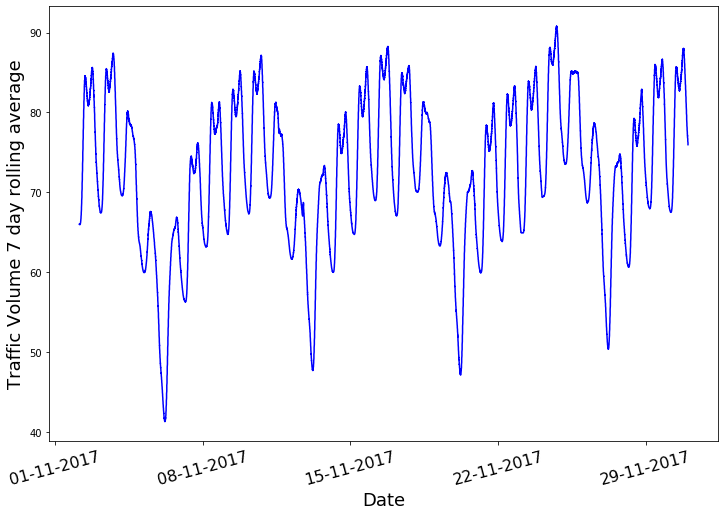

In [10]:
#Plot the rolling average
plt.figure(figsize=(12,8)) 

plt.plot(dfmonth.Date_IntervalStart.values,dfmonth.TotalVolume.rolling(4*24*7).mean(),color='blue')

plt.xlabel('Date',fontsize=18)
plt.ylabel('Traffic Volume 7 day rolling average',fontsize=18)

x1=pd.to_datetime('20171101', format='%Y%m%d')
x2=pd.to_datetime('20171108', format='%Y%m%d') 
x3=pd.to_datetime('20171115', format='%Y%m%d') 
x4=pd.to_datetime('20171122', format='%Y%m%d') 
x5=pd.to_datetime('20171129', format='%Y%m%d') 

plt.xticks([x1,x2,x3,x4,x5],rotation=15,fontsize=16)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

plt.show()

Are there more insigts we can get from this already?
Let's look at the full dataset again, but break it down into some kind of interesting subset.

In [11]:
#Break up the data into interesting pieces.
#Trucks or Cars, and where they have joined the tunnel
ix_car=df.loc[(df['VehicleClass']=='Car')]
ix_truck=df.loc[(df['VehicleClass']=='Truck')]

ix_carE=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='E')]
ix_carN=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='N')]
ix_carW=df.loc[(df['VehicleClass']=='Car') & (df['GantryDirection']=='W')]

ix_truckE=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='E')]
ix_truckN=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='N')]
ix_truckW=df.loc[(df['VehicleClass']=='Truck') & (df['GantryDirection']=='W')]

/home/nbutter/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/nbutter/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


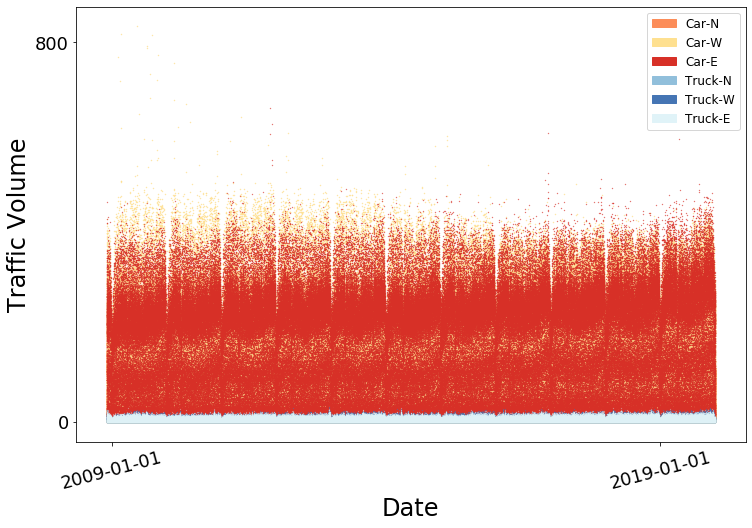

In [12]:
#Now mkae the same plot again, but plot each car/truck/entry seperately

#volume=pd.Series(df["TotalVolume"].values)
plt.figure(figsize=(12,8)) 


l1=plt.plot(ix_carN["Date_IntervalStart"],ix_carN["TotalVolume"].values,
         color='#fc8d59', marker='o',markersize=0.5,linewidth=0.0)
l2=plt.plot(ix_carW["Date_IntervalStart"],ix_carW["TotalVolume"].values,
         color='#fee090', marker='o',markersize=0.4,linewidth=0.0)
l3=plt.plot(ix_carE["Date_IntervalStart"],ix_carE["TotalVolume"].values,
         color='#d73027', marker='o',markersize=0.3,linewidth=0.0)

l4=plt.plot(ix_truckN["Date_IntervalStart"],ix_truckN["TotalVolume"].values,
         color='#91bfdb', marker='.',markersize=0.5,linewidth=0.0)
l5=plt.plot(ix_truckW["Date_IntervalStart"],ix_truckW["TotalVolume"].values,
         color='#4575b4', marker='.',markersize=0.4,linewidth=0.0)
l6=plt.plot(ix_truckE["Date_IntervalStart"],ix_truckE["TotalVolume"].values,
         color='#e0f3f8', marker='.',markersize=0.3,linewidth=0.0)



plt.xlabel('Date',fontsize=24)
plt.ylabel('Traffic Volume',fontsize=24)
plt.yticks([0,800],fontsize=18)

x1=pd.to_datetime('20090101', format='%Y%m%d')
x2=pd.to_datetime('20190101', format='%Y%m%d')           
plt.xticks([x1,x2],rotation=15,fontsize=18)

carN = mpatches.Patch(color='#fc8d59', label='Car-N')
carW = mpatches.Patch(color='#fee090', label='Car-W')
carE = mpatches.Patch(color='#d73027', label='Car-E')
truckN = mpatches.Patch(color='#91bfdb', label='Truck-N')
truckW = mpatches.Patch(color='#4575b4', label='Truck-W')
truckE = mpatches.Patch(color='#e0f3f8', label='Truck-E')
plt.legend(handles=[carN,carW,carE,truckN,truckW,truckE],fontsize=12)


2017-10-15 00:00:00


(736617.0, 736678.0)

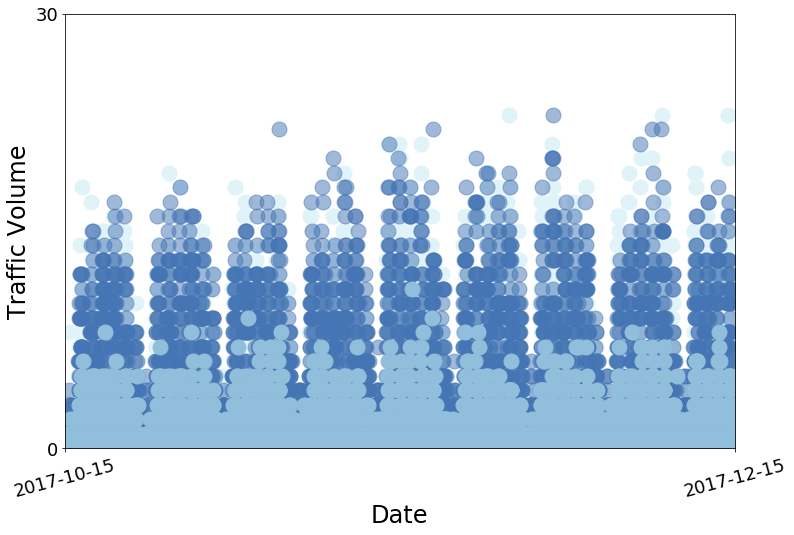

In [13]:
#volume=pd.Series(df["TotalVolume"].values)
plt.figure(figsize=(12,8)) 
# plt.plot(ix_carE["Date_IntervalStart"],ix_carE["TotalVolume"].values,
#          color='sandybrown', marker='o',markersize=3,linewidth=0.0)

# plt.plot(ix_carN["Date_IntervalStart"],ix_carN["TotalVolume"].values,
#          color='moccasin', marker='o',markersize=2,linewidth=0.0)

# plt.plot(ix_carW["Date_IntervalStart"],ix_carW["TotalVolume"].values,
#          color='tan', marker='o',markersize=1,linewidth=0.0)

plt.plot(ix_truckE["Date_IntervalStart"],ix_truckE["TotalVolume"].values,
         color='#e0f3f8',marker='o',markersize=15,markerfacecoloralt='#e0f3f8',linewidth=0,alpha=1)

plt.plot(ix_truckW["Date_IntervalStart"],ix_truckW["TotalVolume"].values,
         color='#4575b4',marker='o',markersize=15,markerfacecoloralt='#4575b4',linewidth=0,alpha=0.5)

plt.plot(ix_truckN["Date_IntervalStart"],ix_truckN["TotalVolume"].values,
         color='#91bfdb',marker='o',markersize=15,markerfacecoloralt='#91bfdb',linewidth=0,alpha=1)

plt.xlabel('Date',fontsize=24)
plt.ylabel('Traffic Volume',fontsize=24)

plt.yticks([0,30],fontsize=18)

#Here we are plotting the whole dataset, but just restricitng the axis.
x1=pd.to_datetime('20171015', format='%Y%m%d')
x2=pd.to_datetime('20171215', format='%Y%m%d')           

xr = pd.date_range(start=x1, end=x2, periods=2)
print(x1)
plt.xticks(xr,rotation=15,fontsize=18)

plt.ylim([0,30])
plt.xlim([x1,x2])

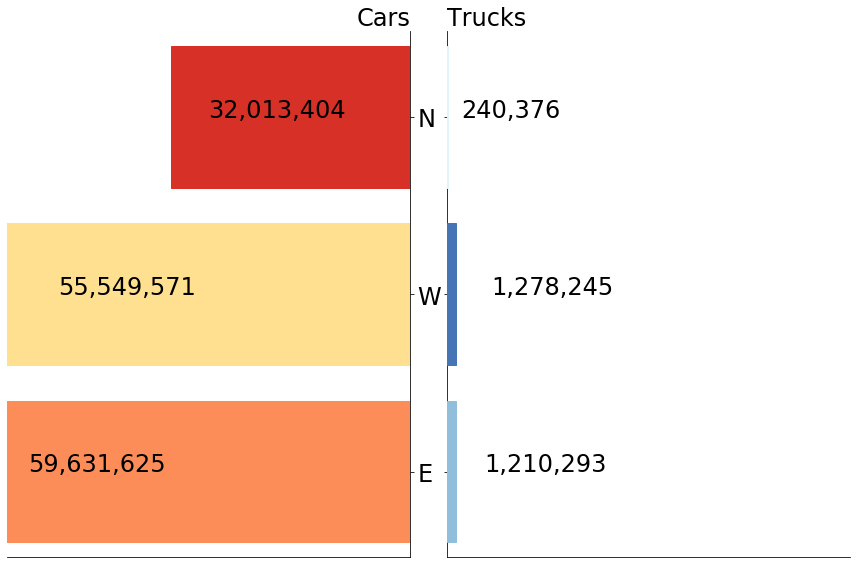

In [14]:
# Data
states = ["E", "N", "W"]
trucks = np.array([ix_truckE["TotalVolume"].sum(),
                  ix_truckN["TotalVolume"].sum(),
                  ix_truckW["TotalVolume"].sum()])

cars = np.array([ix_carE["TotalVolume"].sum(),
                  ix_carN["TotalVolume"].sum(),
                  ix_carW["TotalVolume"].sum()])


# Sort by number of sales staff
idx = cars.argsort()[::-1]
states, trucks, cars = [np.take(x, idx) for x in [states, trucks, cars]]

y = np.arange(cars.size)

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(12,8))

barlist=axes[1].barh(y, trucks, align='center', color='#e0f3f8', zorder=10)
axes[1].set_title('Trucks',loc='left',fontsize=24)
barlist[0].set_color('#91bfdb')
barlist[1].set_color('#4575b4')
barlist[2].set_color('#e0f3f8')

barlist=axes[0].barh(y, cars, align='center', color='#d73027', zorder=10)
#axes[0].set(title='Number of Cars')
axes[0].set_title('Cars',loc='right',fontsize=24)
barlist[0].set_color('#fc8d59')
barlist[1].set_color('#fee090')
barlist[2].set_color('#d73027')

 
axes[1].set(xticks=[])
axes[0].set(xticks=[])

axes[1].set_xlim([0,54000000])
axes[0].set_xlim([0,54000000])

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=states)
axes[0].set_yticklabels(states,fontsize=24)
axes[0].yaxis.tick_right()

axes[0].spines["top"].set_visible(False)
axes[0].spines["left"].set_visible(False)
#axes[0].spines["bottom"].set_visible(False)

axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
#axes[1].spines["bottom"].set_visible(False)
#axes[0].axis('off')
#axes[1].axis('off')

for ax in axes.flat:
    ax.margins(0.03)

fig.tight_layout()
fig.subplots_adjust(wspace=0.09)

axes[1].text(2000000,2,"{:,}".format(ix_truckN["TotalVolume"].sum()),fontsize=24)
axes[1].text(6000000,1,"{:,}".format(ix_truckW["TotalVolume"].sum()),fontsize=24)
axes[1].text(5000000,0,"{:,}".format(ix_truckE["TotalVolume"].sum()),fontsize=24)
axes[1].text(-32000000,2,"{:,}".format(ix_carN["TotalVolume"].sum()),fontsize=24)
axes[1].text(-52000000,1,"{:,}".format(ix_carW["TotalVolume"].sum()),fontsize=24)
axes[1].text(-56000000,0,"{:,}".format(ix_carE["TotalVolume"].sum()),fontsize=24)


plt.show()



Plot the data again, in a different format.

In [15]:
#Uses ~50GB memory to plot entire data set. So either run on HPC or adjust to monthly values 
ix_car=dfmonth.loc[(dfmonth['VehicleClass']=='Car')]
ix_truck=dfmonth.loc[(dfmonth['VehicleClass']=='Truck')]

ix_carE=dfmonth.loc[(dfmonth['VehicleClass']=='Car') & (dfmonth['GantryDirection']=='E')]
ix_carN=dfmonth.loc[(dfmonth['VehicleClass']=='Car') & (dfmonth['GantryDirection']=='N')]
ix_carW=dfmonth.loc[(dfmonth['VehicleClass']=='Car') & (dfmonth['GantryDirection']=='W')]

ix_truckE=dfmonth.loc[(dfmonth['VehicleClass']=='Truck') & (dfmonth['GantryDirection']=='E')]
ix_truckN=dfmonth.loc[(dfmonth['VehicleClass']=='Truck') & (dfmonth['GantryDirection']=='N')]
ix_truckW=dfmonth.loc[(dfmonth['VehicleClass']=='Truck') & (dfmonth['GantryDirection']=='W')]

x1=pd.to_datetime('2017127', format='%Y%m%d')
x2=pd.to_datetime('20171022', format='%Y%m%d')

In [16]:
#Subset the data we need
datesTruckN=ix_truckN["Date_IntervalStart"]
volumeTruckN=ix_truckN["TotalVolume"].values

datesTruckW=ix_truckW["Date_IntervalStart"]
volumeTruckW=ix_truckW["TotalVolume"].values

datesTruckE=ix_truckE["Date_IntervalStart"]
volumeTruckE=ix_truckE["TotalVolume"].values
       
datesCarN=ix_carN["Date_IntervalStart"]
volumeCarN=ix_carN["TotalVolume"].values

datesCarW=ix_carW["Date_IntervalStart"]
volumeCarW=ix_carW["TotalVolume"].values

datesCarE=ix_carE["Date_IntervalStart"]
volumeCarE=ix_carE["TotalVolume"].values

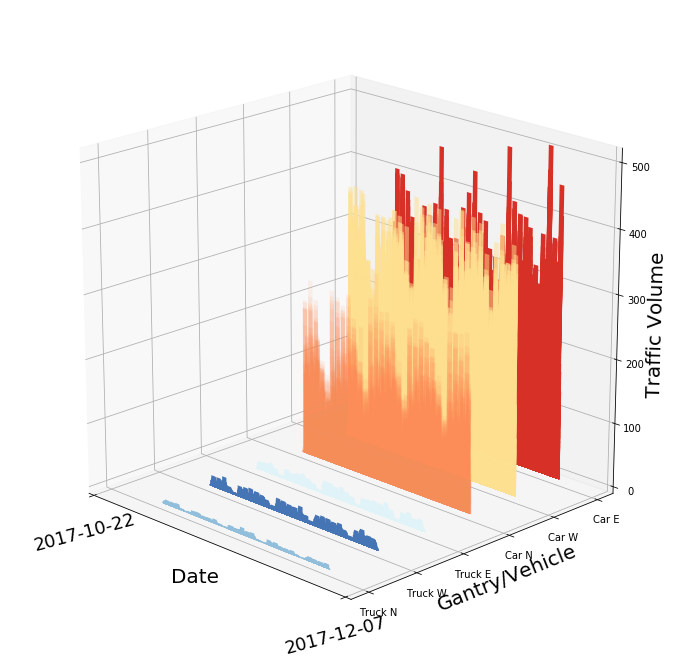

In [17]:
#Make the plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

#plt.figure(figsize=(12,8)) 

ax.bar(datesTruckN,volumeTruckN, zs=0, zdir='y',color='#91bfdb')
ax.bar(datesTruckW,volumeTruckW, zs=20, zdir='y',color='#4575b4')
ax.bar(datesTruckE,volumeTruckE, zs=40, zdir='y',color='#e0f3f8')
ax.bar(datesCarN,volumeCarN, zs=60, zdir='y',color='#fc8d59',alpha=0.1)
ax.bar(datesCarW,volumeCarW, zs=80, zdir='y',color='#fee090',alpha=0.5)
ax.bar(datesCarE,volumeCarE, zs=100, zdir='y',color='#d73027')

xr = pd.date_range(start=x1, end=x2, periods=2)
plt.xticks(xr,rotation=15,fontsize=18)

ax.set_ylabel('Gantry/Vehicle',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_zlabel('Traffic Volume',fontsize=20)

#ax.set_zticks([0,100,200,300,400])

ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(["Truck N", "Truck W", "Truck E", "Car N", "Car W", "Car E"])

#plt.zticks([0,30],fontsize=18)
#plt.xticks([0,30],fontsize=18)

ax.view_init(elev=20., azim=-45)


plt.show()
